# Convert 1D Simulation Results from Delft3D FM to NetworkX — *Eindhoven Case Study*

This notebook demonstrates how to use the `Delft3dfmDatasetWrapper` to:

###  1. Create networkX graph from Delft3DFM 1D model
- Load a 1D mesh from a `Delft3D FM 1D` NetCDF file
- Construct a `networkx` graph from the mesh
- Load time series simulation results (e.g., water level, flow rate)
- Assign simulation results to graph nodes and edges as time-varying attributes

###  2. Add Static Geometry Attributes
- Link node attributes (e.g., manhole IDs) from shapefiles
- Link edge attributes (e.g., branch names) from shapefiles

###  3. Load Multiple Simulations (Optional)
- Read a folder of NetCDF outputs and store them as a dataset list

---

## ⚙️ Requirements

To use this notebook, prepare the following:

### 📂 Input Files
- **Model results**: NetCDF map files containing 1D simulation outputs (e.g., `_map.nc`)
- **Model geometry**: Shapefiles exported from the Delft3D-FM GUI (e.g., manholes, branches)

### 🧪 Dependencies
Make sure the following packages are installed:

- [`hydromt-delft3dfm`](https://deltares.github.io/hydromt-delft3dfm) ≥ 0.3.0
- `hybridurb` (requires development installation)


In [1]:
from hybridurb.datasetutils.dataset_from_delft3dfm import Delft3dfmDatasetWrapper  # Replace with your actual module path
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\li_xn\AppData\Local\miniconda3\envs\hydromt-delft3dfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🧩 Start building

In [2]:
# Initialize the wrapper from netcdf
Eindhoven_Wrapper = Delft3dfmDatasetWrapper.from_netcdf(
    r"..\data\Eindhoven\Simulations\Hydrogram Stresstestbui 07.bui_map_output.nc"
)

In [3]:
# Add node attributes from manhole shapefile
Eindhoven_Wrapper.add_graph_attributes_from_shapefile(
    shp=r"..\data\Eindhoven\GUI_exports\Eindhoven_Manholes.shp",
    attribute_cols=["Name"],
    target="node",
    search_radius=0.1,
    col_mapping={"Name": "manhole_name"},
)

In [4]:
# Add node attributes from compartment shapefile
Eindhoven_Wrapper.add_graph_attributes_from_shapefile(
    shp=r"..\data\Eindhoven\GUI_exports\Eindhoven_Compartments_Compartment.shp",
    attribute_cols=["Name", "BottomLevel", "SurfaceLeve", "ManholeLeng", "ManholeWidt"],
    target="node",
    search_radius=0.1,
    col_mapping={"Name": "compartment_name", "BottomLevel":"bedlev", "SurfaceLeve":"streetlev", "ManholeLeng":"length", "ManholeWidt":"width"},
)

In [5]:
# Add edge attributes from branch shapefile
Eindhoven_Wrapper.add_graph_attributes_from_shapefile(
    shp=r"..\data\Eindhoven\GUI_exports\Eindhoven_Branches.shp",
    attribute_cols=["Name"],
    target="edge",
    search_radius=0.1,
    col_mapping={"Name": "branch_name"},
)

In [6]:
# Add edge attributes from pipe shapefile
Eindhoven_Wrapper.add_graph_attributes_from_shapefile(
    shp=r"..\data\Eindhoven\GUI_exports\Eindhoven_Pipes.shp",
    attribute_cols=["Level sourc", "Level targe"],
    target="edge",
    search_radius=0.1,
    col_mapping={"Level sourc": "invertlev_up", "Level targe":"invertlev_dn"},
)

In [7]:
# Add edge attributes from sewer connection shapefile
Eindhoven_Wrapper.add_graph_attributes_from_shapefile(
    shp=r"..\data\Eindhoven\GUI_exports\Eindhoven_Sewer Connections.shp",
    attribute_cols=["Sewer Speci"],
    target="edge",
    search_radius=0.1,
    col_mapping={"Sewer Speci": "structuretype"},
)

In [ ]:
# load multiple datasets (can take a while)
Eindhoven_Wrapper.load_simulations_from_folder(folder=r"..\data\Eindhoven\Simulations")
print(f"Number of datasets loaded: {len(Eindhoven_Wrapper.dataset_list)}")

## 🕸 Visualize Graph (For a Quick Check)

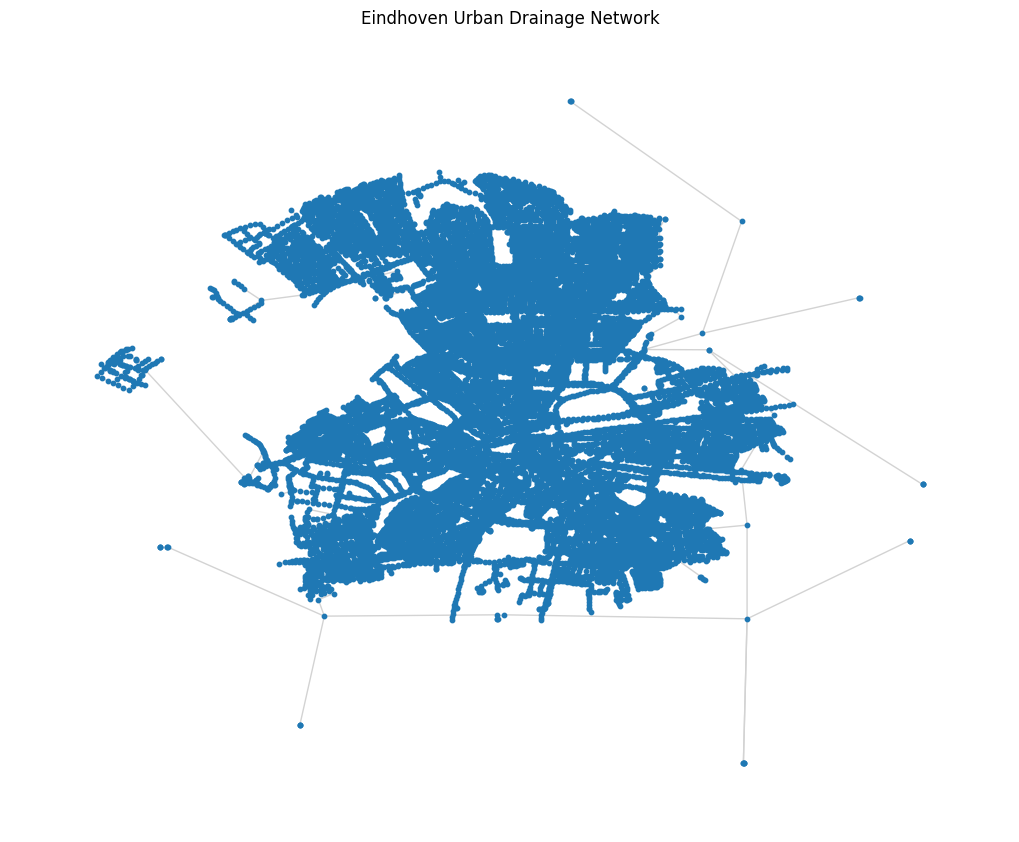

In [8]:
# Plot network graph (nodes only)
pos = {n: (d['x'], d['y']) for n, d in Eindhoven_Wrapper.G.nodes(data=True)}

plt.figure(figsize=(10, 8))
nx.draw(Eindhoven_Wrapper.G, pos=pos, node_size=10, edge_color='lightgrey')
plt.title("Eindhoven Urban Drainage Network")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## 📈 Explore Time Series (Another Quick check)

            A12502_A12504_0.000  A12502_A12504_21.310  A12754_A12756_68.140  \
2023-01-01                  NaN                   NaN                   NaN   

            A13004_A13052_0.000  A13004_A13052_52.000  A13020_A13022_0.000  \
2023-01-01                  NaN                   NaN                  NaN   

            A13020_A13022_64.670  A12752_A1275Y_4.250  A13004_A13034_75.330  \
2023-01-01                   NaN                  NaN                   NaN   

            A12506_A12752_56.860  ...  PMP35_1.000  PMP10_1.000  PMP8_1.000  \
2023-01-01                   NaN  ...          NaN          NaN         NaN   

            PMP29_1.000  PMP44_1.000  DRL1_1.000  DRL6_1.000  DRL2_1.000  \
2023-01-01          NaN          NaN         NaN         NaN         NaN   

            DRL8_1.000  DRL3_1.000  
2023-01-01         NaN         NaN  

[1 rows x 20205 columns]


<Axes: title={'center': 'Water Level at Manhole 0A12502'}>

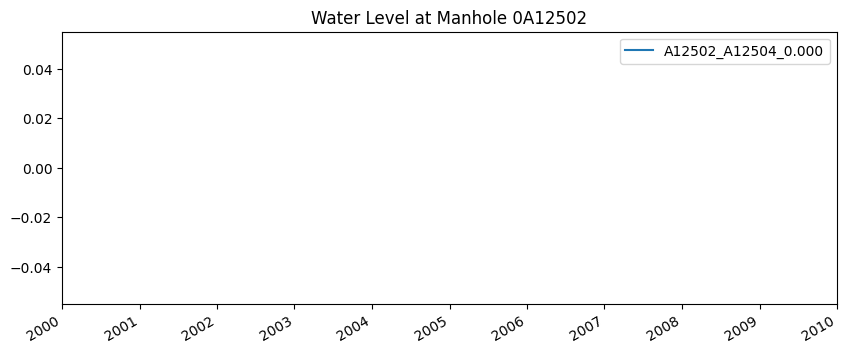

In [21]:
# Access node-level simulation (e.g., water level)
df_heads = Eindhoven_Wrapper.dataset_list[0]["heads_raw_data"]
print(df_heads.head())
# Plot water level at a specific node (e.g., node ID A12502_A12504_0.000)
nodeid = "A12502_A12504_0.000"
manholeid = Eindhoven_Wrapper.G.nodes[nodeid]["manhole_name"]
df_heads[[nodeid]].plot(title=f"Water Level at Manhole {manholeid}", figsize=(10, 4))

In [22]:
# Check what attributes were added to a node
Eindhoven_Wrapper.G.nodes[nodeid]

{'x': 155421.569,
 'y': 385549.015,
 'branch': 0,
 'offset': 0.0,
 'h_x': 2023-01-01   NaN
 Name: A12502_A12504_0.000, dtype: float64,
 'runoff': 2023-01-01    0.0
 Name: A12502_A12504_0.000, dtype: float64,
 'manhole_name': '0A12502',
 'compartment_name': '0A12502',
 'bedlev': np.float64(18.1),
 'streetlev': np.float64(19.75),
 'length': np.float64(0.8),
 'width': np.float64(0.8)}

<Axes: title={'center': 'Discharge on edge A12502_A12504'}>

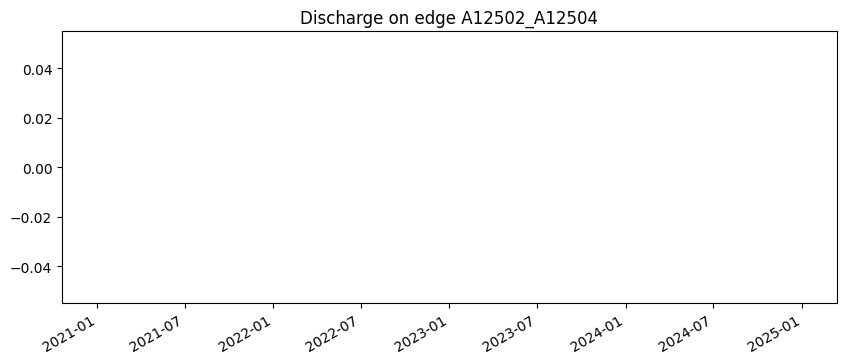

In [32]:
# Check flowrate time series on a specific edge
edge = list(Eindhoven_Wrapper.G.edges)[0]
edgeid = Eindhoven_Wrapper.G.edges[edge]["branch_name"]
df_q = Eindhoven_Wrapper.dataset_list[0]["flowrate_raw_data"]
df_q[[edge]].plot(title=f"Discharge on edge {edgeid}", figsize=(10, 4), legend=False)

## 📂 Additional file handeling

In [33]:
# Save wrapper state to disk 
Eindhoven_Wrapper.save_to_pickle("Eindhoven_Wrapper.pkl")

Wrapper state saved to Eindhoven_Wrapper.pkl


In [34]:
# load wrapper state from disk (optional) 
Eindhoven_Wrapper = Delft3dfmDatasetWrapper.load_from_pickle("Eindhoven_Wrapper.pkl")

Wrapper loaded from Eindhoven_Wrapper.pkl
